In [1]:
# changing cwd
%cd ..

c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp


## Load packages

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle

cmap = 'PRGn'

In [3]:
from src.inductive_bias import IB
ib = IB() #instantiate inductive bias package

[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\SimulationData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\PosteriorData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\TrainedCLF.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\EstimatedData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\HellingerData.pickle ] loaded
Size of the S-XOR: (6322,)                    
Size of the Spiral: (6276,)                    
Size of the whole dataset: (12598, 7)

Size of the S-XOR after adding hellinger: (6322, 8)            
Size of the Spiral after adding hellinger: (6276, 8)


In [4]:
ib.load_sampledData()

[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\SampledData.pickle ] loaded


## Time and Date of the experiment

In [5]:
print(ib.date)

2021-04-20 06:46:25.345784


In [6]:
uX = ib.mask
uX0, uX1 = uX[:,0], uX[:,1]
label = ib.mtype[:3] + ['Human'] #excluding QDA
fsize= 18

Wall time: 52min 57s


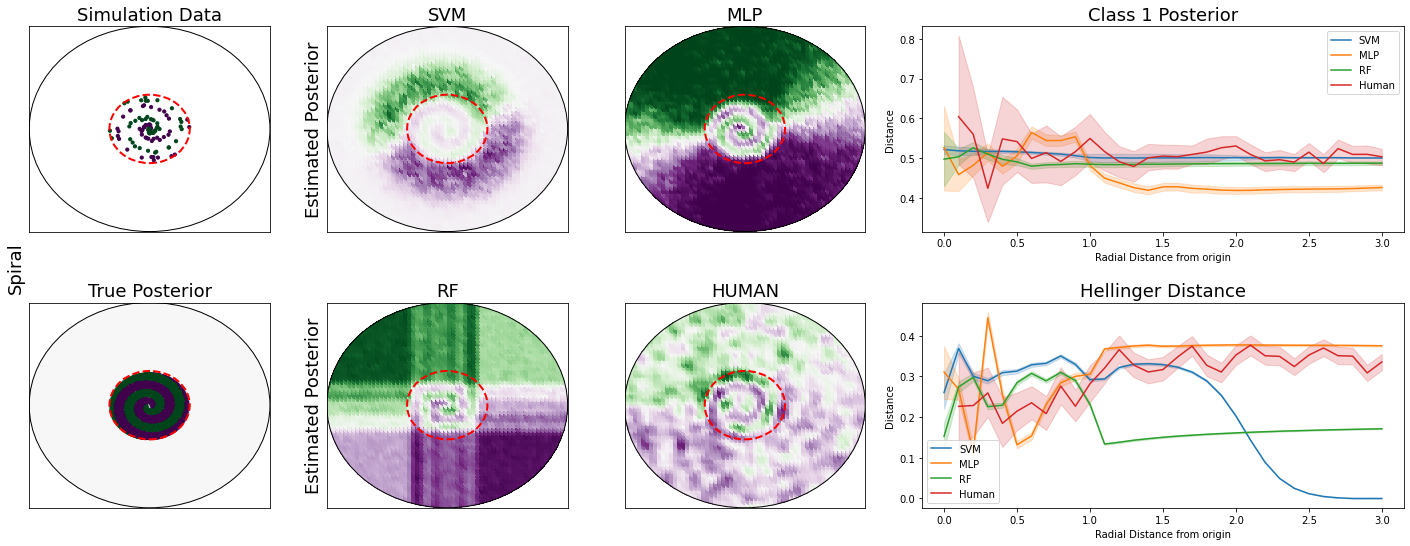

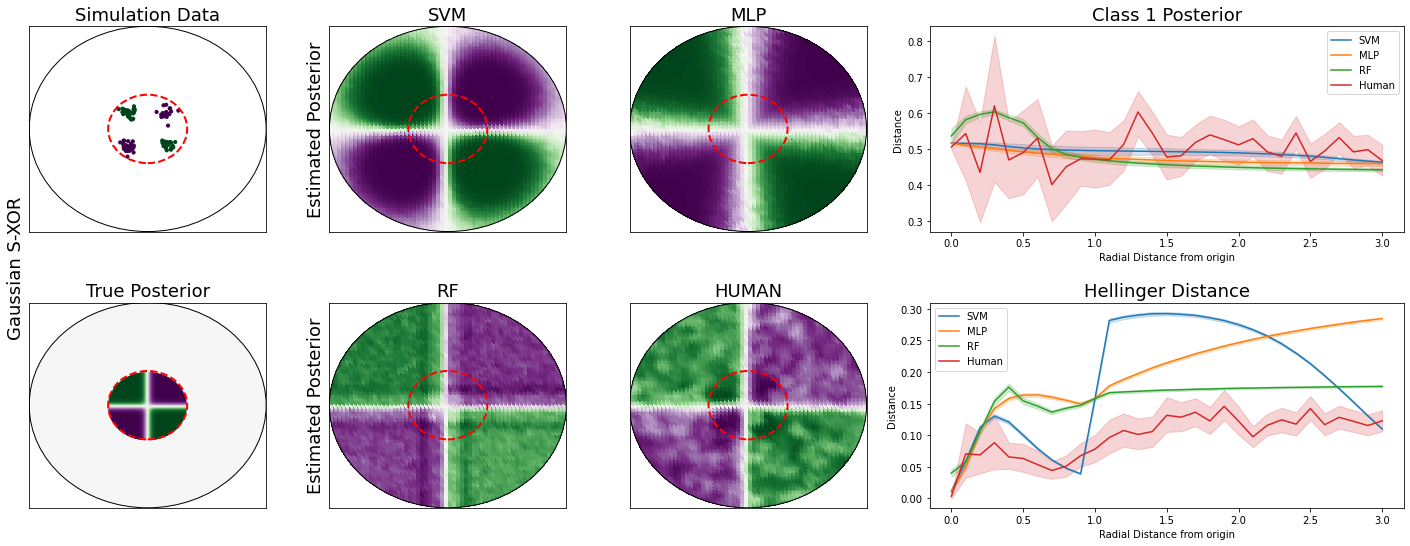

In [7]:
%%time
'''
This figure contains simulation data at idx[0,0], true posterior at idx[1,0], 
estimated posterior at idx[i=1,2|j=1,2], class 1 posterior at idx[0,3], and hellinger distance at idx[1,3]
'''
row = 2
col = 4
interp_method = 'linear'  # interpolation methods
fname = ['spiral', 'sxor']

for ii, j in enumerate([2, 4]):

    cnt = 0

    widths = [4, 4, 4, 8]
    fig = plt.figure(figsize=(4*(col+1), 4*row))
    spec = fig.add_gridspec(ncols=col, nrows=row, width_ratios=widths)

    ax = fig.add_subplot(111)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')

    ax.set_ylabel(ib.dtype[j], fontsize=18)

    for k in range(row):
        for i in range(col):
            cnt += 1

            axs = fig.add_subplot(spec[k, i])

            # simulation dataset
            if cnt == 1:
                pcm = axs.scatter(ib.train_X[j][:,0], ib.train_X[j][:,1], c=ib.train_y[j], cmap=cmap, s=10)

            # true posterior
            elif cnt == 5:
                xx = ib.truepst[1][j][0]
                yy = ib.truepst[1][j][1]
                cc = ib.truepst[1][j][2]
                pcm = axs.scatter(xx, yy, c=cc, cmap=cmap, s=1)

            elif cnt in [2,3,6,7]:
                # estimated posterior (SVM)
                if cnt == 2:
                    mtype_i = ib.estpst_sample[ii][0]
                    axs.set_title(ib.mtype[0], fontsize=fsize)
                # estimated posterior (MLP)
                elif cnt == 3:
                    mtype_i = ib.estpst_sample[ii][1]
                    axs.set_title(ib.mtype[1], fontsize=fsize)
                # estimated posterior (RF)
                elif cnt == 6:
                    mtype_i = ib.estpst_sample[ii][2]
                    axs.set_title(ib.mtype[2], fontsize=fsize)
                # human estimates
                elif cnt == 7:
                    mtype_i = np.column_stack([ib.human[ii][:,3], ib.human[ii][:,5], ib.human[ii][:,0]])    
                    axs.set_title('HUMAN', fontsize=fsize)

                mtype_i = ib.pointwise_gridAverage(mtype_i).to_numpy()
                xy, original, down, alls = ib.smooth_gaussian_distance(mtype_i, step=0.01, method='mean', sigma=1, k=10)
                pcm = axs.scatter(x=np.array(xy)[:,0], y=np.array(xy)[:,1], c=alls, cmap=cmap)             

            # radial plot
            elif cnt in [4,8]:
                for i in range(4):                    
                    if i == 3:        
                        hmask = np.column_stack([ib.human[ii][:,3], ib.human[ii][:,5]])
                        if cnt == 4:
                            temp = ib.get_radialDist(np.column_stack([hmask, ib.human[ii][:,0]]).astype(float))
                        elif cnt == 8:
                            temp = ib.get_radialDist(np.column_stack([hmask, ib.human[ii][:,6]]).astype(float))
                    else:
                        if cnt == 4:
                            temp = ib.get_radialDist(np.column_stack([ib.mask, ib.estpst[1][j][i]]))
                        elif cnt == 8:
                            temp = ib.get_radialDist(np.column_stack([ib.mask, ib.hdist[1][j][i]]))

                    temp2 = pd.DataFrame(temp[1]).T
                    temp2.columns = temp[0]
                    temp2 = temp2.melt().dropna()
                    temp2.columns=['Radial Distance from origin', 'Distance']
                    sns.lineplot(data=temp2, x=temp2.columns[0], y=temp2.columns[1], ci=95, label=label[i], ax=axs)
            
            ## figure styling ##
            if cnt != 4 and cnt != 8:                
                circle = Circle((0, 0), 3, linewidth=1, edgecolor='k', facecolor='none') # outer bounding circle                
                axs.add_patch(Circle((0, 0), radius=1, linewidth=2, ls='--', edgecolor='r', fill=False)) # inner unit circle                
                axs.add_patch(circle)
                pcm.set_clip_path(circle)

                axs.set_xlim([-3, 3])
                axs.set_ylim([-3, 3])

            if k == 0 and i == 0:
                axs.set_title('Simulation Data', fontsize=fsize)

            if k == 1 and i == 0:
                axs.set_title('True Posterior', fontsize=fsize)

            if k == 0 and i == 3:
                axs.set_title('Class 1 Posterior', fontsize=fsize)

            if k == 1 and i == 3:
                axs.set_title('Hellinger Distance', fontsize=fsize)

            if i == 1 and (k == 0 or k == 1):
                axs.set_ylabel('Estimated Posterior', fontsize=fsize)

            if i < 3:
                axs.set_xticks([])
                axs.set_yticks([])

    plt.tight_layout(pad=2)
    plt.savefig(f'figs/[20210419_resampled_figures]_model_human_figure_{fname[ii]}_{str(ib.date.date())}.png', bbox_inches='tight')